# Libraries

In [12]:
# Reading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import optuna
from optuna import Trial
from scipy.stats import norm
import scipy.stats as stats
import joblib

# Ignore warninga and view all columns
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)

In [13]:
# Reading the dataset
df = pd.read_csv('../data/fps-dataset-feature.csv')
print(df.shape)
df.head()

(186036, 49)


,CpuName,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuFrequency,CpuMultiplier,CpuMultiplierUnlocked,CpuProcessSize,CpuTDP,CpuTurboClock,GpuName,GpuArchitecture,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuBus nterface,GpuDieSize,GpuDirectX,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuMemoryType,GpuOpenCL,GpuOpenGL,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuShaderModel,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GpuVulkan,GameName,GameResolution,GameSetting,FPS,GpuCpuRatio,CacheCoreRatio,CpuOverclockPotential,EffectiveMemory,PerformanceClockRatio,PerformancePerWatt,CpuCoreThreadRatio,CpuPowerIndex,GpuAverageClock
0,Intel Core i7-920,4.0,8.0,133.0,256.0,1024.0,8.0,2666.0,20.0,0,45.0,130.0,2933.0,AMD Radeon RX 480,GCN 4.0,256000.0,1120.0,1266.0,PCIe 3.0 x16,0.000232,12,5834000.0,256.0,8000.0,GDDR5,2.0,4.6,40510.0,14.0,32.0,6.4,2304.0,144.0,182300.0,5700.0,1.2.131,counterStrikeGlobalOffensive,1080.0,low,70.0,0.431640,322.0,21.052632,65536000.0,2.316746,1023.508772,0.5,93856.0,1193.0
1,Intel Core i7-920,4.0,8.0,133.0,256.0,1024.0,8.0,2666.0,20.0,0,45.0,130.0,2933.0,AMD Radeon RX 480,GCN 4.0,256000.0,1120.0,1266.0,PCIe 3.0 x16,0.000232,12,5834000.0,256.0,8000.0,GDDR5,2.0,4.6,40510.0,14.0,32.0,6.4,2304.0,144.0,182300.0,5700.0,1.2.131,counterStrikeGlobalOffensive,1080.0,low,230.0,0.431640,322.0,21.052632,65536000.0,2.316746,1023.508772,0.5,93856.0,1193.0
2,Intel Core i5-4690,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,0,22.0,84.0,3800.0,NVIDIA GeForce GTX 1080 11Gbps,Pascal,352300.0,1607.0,1733.0,PCIe 3.0 x16,0.000314,12,8873000.0,256.0,8000.0,GDDR5X,1.2,4.6,110900.0,16.0,64.0,6.4,2560.0,160.0,277300.0,7200.0,1.2.131,counterStrikeGlobalOffensive,1080.0,low,250.0,0.456053,321.5,37.000000,90188800.0,2.192729,1232.361111,1.0,91200.0,1670.0
3,Intel Core i5-4690,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,0,22.0,84.0,3800.0,NVIDIA GeForce GTX 1080 11Gbps,Pascal,352300.0,1607.0,1733.0,PCIe 3.0 x16,0.000314,12,8873000.0,256.0,8000.0,GDDR5X,1.2,4.6,110900.0,16.0,64.0,6.4,2560.0,160.0,277300.0,7200.0,1.2.131,counterStrikeGlobalOffensive,1080.0,low,300.0,0.456053,321.5,37.000000,90188800.0,2.192729,1232.361111,1.0,91200.0,1670.0
4,Intel Core i5-4690,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,0,22.0,84.0,3800.0,AMD Radeon R7 260X,GCN 2.0,104000.0,1100.0,1100.0,PCIe 3.0 x16,0.000160,12,1971000.0,128.0,2000.0,GDDR5,2.0,4.6,17600.0,28.0,16.0,6.3,896.0,56.0,61600.0,2080.0,1.2.131,counterStrikeGlobalOffensive,1080.0,low,200.0,0.289474,321.5,37.000000,13312000.0,3.454545,947.596154,1.0,91200.0,1100.0


In [14]:
# We drop duplicated rows
print(df[df.duplicated()].shape)
df.drop_duplicates(inplace=True)

(8, 49)


In [15]:
# Find rows where Cpu name are equal and Gpu name are equal and Gamesetting are equal
testing = df[df.duplicated(subset=['CpuName', 'GpuName', 'GameName', 'GameSetting'], keep=False)]
testing[(testing['CpuName'] == 'Intel Core i5-4690') & (testing['GpuName'] == 'NVIDIA GeForce GTX 1080 11Gbps') & (testing['GameName'] == 'counterStrikeGlobalOffensive')]

,CpuName,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuFrequency,CpuMultiplier,CpuMultiplierUnlocked,CpuProcessSize,CpuTDP,CpuTurboClock,GpuName,GpuArchitecture,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuBus nterface,GpuDieSize,GpuDirectX,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuMemoryType,GpuOpenCL,GpuOpenGL,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuShaderModel,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GpuVulkan,GameName,GameResolution,GameSetting,FPS,GpuCpuRatio,CacheCoreRatio,CpuOverclockPotential,EffectiveMemory,PerformanceClockRatio,PerformancePerWatt,CpuCoreThreadRatio,CpuPowerIndex,GpuAverageClock
2,Intel Core i5-4690,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,0,22.0,84.0,3800.0,NVIDIA GeForce GTX 1080 11Gbps,Pascal,352300.0,1607.0,1733.0,PCIe 3.0 x16,0.000314,12,8873000.0,256.0,8000.0,GDDR5X,1.2,4.6,110900.0,16.0,64.0,6.4,2560.0,160.0,277300.0,7200.0,1.2.131,counterStrikeGlobalOffensive,1080.0,low,250.0,0.456053,321.5,37.0,90188800.0,2.192729,1232.361111,1.0,91200.0,1670.0
3,Intel Core i5-4690,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,0,22.0,84.0,3800.0,NVIDIA GeForce GTX 1080 11Gbps,Pascal,352300.0,1607.0,1733.0,PCIe 3.0 x16,0.000314,12,8873000.0,256.0,8000.0,GDDR5X,1.2,4.6,110900.0,16.0,64.0,6.4,2560.0,160.0,277300.0,7200.0,1.2.131,counterStrikeGlobalOffensive,1080.0,low,300.0,0.456053,321.5,37.0,90188800.0,2.192729,1232.361111,1.0,91200.0,1670.0
14100,Intel Core i5-4690,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,0,22.0,84.0,3800.0,NVIDIA GeForce GTX 1080 11Gbps,Pascal,352300.0,1607.0,1733.0,PCIe 3.0 x16,0.000314,12,8873000.0,256.0,8000.0,GDDR5X,1.2,4.6,110900.0,16.0,64.0,6.4,2560.0,160.0,277300.0,7200.0,1.2.131,counterStrikeGlobalOffensive,1080.0,high,220.0,0.456053,321.5,37.0,90188800.0,2.192729,1232.361111,1.0,91200.0,1670.0
14101,Intel Core i5-4690,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,0,22.0,84.0,3800.0,NVIDIA GeForce GTX 1080 11Gbps,Pascal,352300.0,1607.0,1733.0,PCIe 3.0 x16,0.000314,12,8873000.0,256.0,8000.0,GDDR5X,1.2,4.6,110900.0,16.0,64.0,6.4,2560.0,160.0,277300.0,7200.0,1.2.131,counterStrikeGlobalOffensive,1080.0,high,250.0,0.456053,321.5,37.0,90188800.0,2.192729,1232.361111,1.0,91200.0,1670.0
14102,Intel Core i5-4690,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,0,22.0,84.0,3800.0,NVIDIA GeForce GTX 1080 11Gbps,Pascal,352300.0,1607.0,1733.0,PCIe 3.0 x16,0.000314,12,8873000.0,256.0,8000.0,GDDR5X,1.2,4.6,110900.0,16.0,64.0,6.4,2560.0,160.0,277300.0,7200.0,1.2.131,counterStrikeGlobalOffensive,1080.0,high,270.0,0.456053,321.5,37.0,90188800.0,2.192729,1232.361111,1.0,91200.0,1670.0
14103,Intel Core i5-4690,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,0,22.0,84.0,3800.0,NVIDIA GeForce GTX 1080 11Gbps,Pascal,352300.0,1607.0,1733.0,PCIe 3.0 x16,0.000314,12,8873000.0,256.0,8000.0,GDDR5X,1.2,4.6,110900.0,16.0,64.0,6.4,2560.0,160.0,277300.0,7200.0,1.2.131,counterStrikeGlobalOffensive,1080.0,high,300.0,0.456053,321.5,37.0,90188800.0,2.192729,1232.361111,1.0,91200.0,1670.0


Nos damos cuenta que existen CpuName, GpuName y Game iguales pero con FPS distintos. Así que sacamos el promedio de FPS para ponerlo en una sola fila, ya que las demás variables dependen de estas 3 características.

In [16]:
# Creating the new dataset with mean FPS in rows that have the same values in the columns
columns_to_check = df.columns.tolist()
columns_to_check.remove('FPS')
df = df.groupby(columns_to_check, as_index=False).agg({'FPS': 'mean'})
print(df.shape)
df.head()

(93695, 49)


,CpuName,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuFrequency,CpuMultiplier,CpuMultiplierUnlocked,CpuProcessSize,CpuTDP,CpuTurboClock,GpuName,GpuArchitecture,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuBus nterface,GpuDieSize,GpuDirectX,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuMemoryType,GpuOpenCL,GpuOpenGL,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuShaderModel,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GpuVulkan,GameName,GameResolution,GameSetting,GpuCpuRatio,CacheCoreRatio,CpuOverclockPotential,EffectiveMemory,PerformanceClockRatio,PerformancePerWatt,CpuCoreThreadRatio,CpuPowerIndex,GpuAverageClock,FPS
0,AMD Athlon 200GE,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,AMD Radeon 550,GCN 4.0,56000.0,1100.0,1183.0,PCIe 3.0 x8,0.000103,12,1211000.0,64.0,2000.0,GDDR5,2.0,4.6,18930.0,14.0,16.0,6.4,512.0,32.0,37860.0,2200.0,1.2.131,fortnite,1080.0,med,0.369688,610.0,31.0,3584000.0,2.704987,550.454545,0.5,25600.0,1141.5,120.0
1,AMD Athlon 200GE,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,AMD Radeon 550,GCN 4.0,56000.0,1100.0,1183.0,PCIe 3.0 x8,0.000103,12,1211000.0,64.0,2000.0,GDDR5,2.0,4.6,18930.0,14.0,16.0,6.4,512.0,32.0,37860.0,2200.0,1.2.131,minecraft,720.0,high,0.369688,610.0,31.0,3584000.0,2.704987,550.454545,0.5,25600.0,1141.5,120.0
2,AMD Athlon 200GE,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,AMD Radeon HD 7750,GCN 1.0,72000.0,800.0,800.0,PCIe 3.0 x16,0.000123,12,819200.0,128.0,1024.0,GDDR5,1.2,4.6,12800.0,28.0,16.0,5.1,512.0,32.0,25600.0,1500.0,1.2.131,grandTheftAuto5,720.0,med,0.250000,610.0,31.0,9216000.0,4.000000,546.133333,0.5,25600.0,800.0,50.0
3,AMD Athlon 200GE,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,AMD Radeon HD 7850,GCN 1.0,153600.0,860.0,860.0,PCIe 3.0 x16,0.000212,12,1761000.0,256.0,2000.0,GDDR5,1.2,4.6,27520.0,28.0,32.0,5.1,1024.0,64.0,55040.0,2800.0,1.2.131,apexLegends,720.0,low,0.268750,610.0,31.0,39321600.0,3.720930,628.928571,0.5,25600.0,860.0,30.0
4,AMD Athlon 200GE,2.0,4.0,100.0,192.0,1024.0,4.0,3200.0,32.0,0,14.0,35.0,3200.0,AMD Radeon HD 7850,GCN 1.0,153600.0,860.0,860.0,PCIe 3.0 x16,0.000212,12,1761000.0,256.0,2000.0,GDDR5,1.2,4.6,27520.0,28.0,32.0,5.1,1024.0,64.0,55040.0,2800.0,1.2.131,apexLegends,720.0,med,0.268750,610.0,31.0,39321600.0,3.720930,628.928571,0.5,25600.0,860.0,30.0


In [17]:
# Verifying that is correct the formula above
df[(df['CpuName'] == 'Intel Core i7-920') & (df['GpuName'] == 'AMD Radeon RX 480') & (df['GameName'] == 'counterStrikeGlobalOffensive')]

,CpuName,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuFrequency,CpuMultiplier,CpuMultiplierUnlocked,CpuProcessSize,CpuTDP,CpuTurboClock,GpuName,GpuArchitecture,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuBus nterface,GpuDieSize,GpuDirectX,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuMemoryType,GpuOpenCL,GpuOpenGL,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuShaderModel,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GpuVulkan,GameName,GameResolution,GameSetting,GpuCpuRatio,CacheCoreRatio,CpuOverclockPotential,EffectiveMemory,PerformanceClockRatio,PerformancePerWatt,CpuCoreThreadRatio,CpuPowerIndex,GpuAverageClock,FPS
86506,Intel Core i7-920,4.0,8.0,133.0,256.0,1024.0,8.0,2666.0,20.0,0,45.0,130.0,2933.0,AMD Radeon RX 480,GCN 4.0,256000.0,1120.0,1266.0,PCIe 3.0 x16,0.000232,12,5834000.0,256.0,8000.0,GDDR5,2.0,4.6,40510.0,14.0,32.0,6.4,2304.0,144.0,182300.0,5700.0,1.2.131,counterStrikeGlobalOffensive,1080.0,low,0.43164,322.0,21.052632,65536000.0,2.316746,1023.508772,0.5,93856.0,1193.0,150.0


In [18]:
# Veryfing with another data
df[(df['CpuName'] == 'Intel Core i5-4690') & (df['GpuName'] == 'NVIDIA GeForce GTX 1080 11Gbps') & (df['GameName'] == 'counterStrikeGlobalOffensive')]

,CpuName,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuFrequency,CpuMultiplier,CpuMultiplierUnlocked,CpuProcessSize,CpuTDP,CpuTurboClock,GpuName,GpuArchitecture,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuBus nterface,GpuDieSize,GpuDirectX,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuMemoryType,GpuOpenCL,GpuOpenGL,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuShaderModel,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GpuVulkan,GameName,GameResolution,GameSetting,GpuCpuRatio,CacheCoreRatio,CpuOverclockPotential,EffectiveMemory,PerformanceClockRatio,PerformancePerWatt,CpuCoreThreadRatio,CpuPowerIndex,GpuAverageClock,FPS
51729,Intel Core i5-4690,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,0,22.0,84.0,3800.0,NVIDIA GeForce GTX 1080 11Gbps,Pascal,352300.0,1607.0,1733.0,PCIe 3.0 x16,0.000314,12,8873000.0,256.0,8000.0,GDDR5X,1.2,4.6,110900.0,16.0,64.0,6.4,2560.0,160.0,277300.0,7200.0,1.2.131,counterStrikeGlobalOffensive,1080.0,high,0.456053,321.5,37.0,90188800.0,2.192729,1232.361111,1.0,91200.0,1670.0,260.0
51730,Intel Core i5-4690,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,0,22.0,84.0,3800.0,NVIDIA GeForce GTX 1080 11Gbps,Pascal,352300.0,1607.0,1733.0,PCIe 3.0 x16,0.000314,12,8873000.0,256.0,8000.0,GDDR5X,1.2,4.6,110900.0,16.0,64.0,6.4,2560.0,160.0,277300.0,7200.0,1.2.131,counterStrikeGlobalOffensive,1080.0,low,0.456053,321.5,37.0,90188800.0,2.192729,1232.361111,1.0,91200.0,1670.0,275.0


In [19]:
df.select_dtypes(include='object').columns

Index(['CpuName', 'GpuName', 'GpuArchitecture', 'GpuBus nterface',
       'GpuDirectX', 'GpuMemoryType', 'GpuVulkan', 'GameName', 'GameSetting'],
      dtype='object')

In [20]:
df.to_csv('../data/fps-dataset-feature_clean.csv', index=False)

In [21]:
# Eliminamos las siguientes columnas y las columnas que contienen tipo de memoria HBM y HBM2
delete_colums = ['CpuName', 'GpuName', 'GpuOpenGL', 'GpuShaderModel', 'GpuVulkan']
#df = df[(df['GpuMemoryType'] != 'HBM') & (df['GpuMemoryType'] != 'HBM2')]
df = df.drop(delete_colums, axis=1)
print(df.shape)

(93695, 44)


In [22]:
# Visualizing the quantity of each type of CPU
#cpu = df['CpuName'].value_counts().reset_index()
#cpu.columns = ['CpuName', 'count']
#cpu.T

In [23]:
# Visualizing the quantity of each type of Gpu
#gpu = df['GpuName'].value_counts().reset_index()
#gpu.columns = ['GpuName', 'count']
#gpu.T

In [24]:
# Modify the dataset with only columns that have more than 90% of quantity in CpuName
#cpu_name_counts = df['CpuName'].value_counts()
#threshold = cpu_name_counts.quantile(0.90)
#filtered_cpu_names = cpu_name_counts[cpu_name_counts > threshold].index
#df = df[df['CpuName'].isin(filtered_cpu_names)]
#df.shape

In [25]:
# Modify the dataset to have only columns that have more than 55% of quantity in GpuName
#gpu_name_counts = df['GpuName'].value_counts()
#threshold = gpu_name_counts.quantile(0.55)
#filtered_gpu_names = gpu_name_counts[gpu_name_counts > threshold].index
#df = df[df['GpuName'].isin(filtered_gpu_names)]
#df.shape

In [26]:
# View distribution of count of each cpuname
#sns.set(style="whitegrid")
#plt.figure(figsize=(12, 6))
#sns.barplot(x='CpuName', y='count', data=df['CpuName'].value_counts().reset_index())
#plt.xticks(rotation=90)
#plt.show()

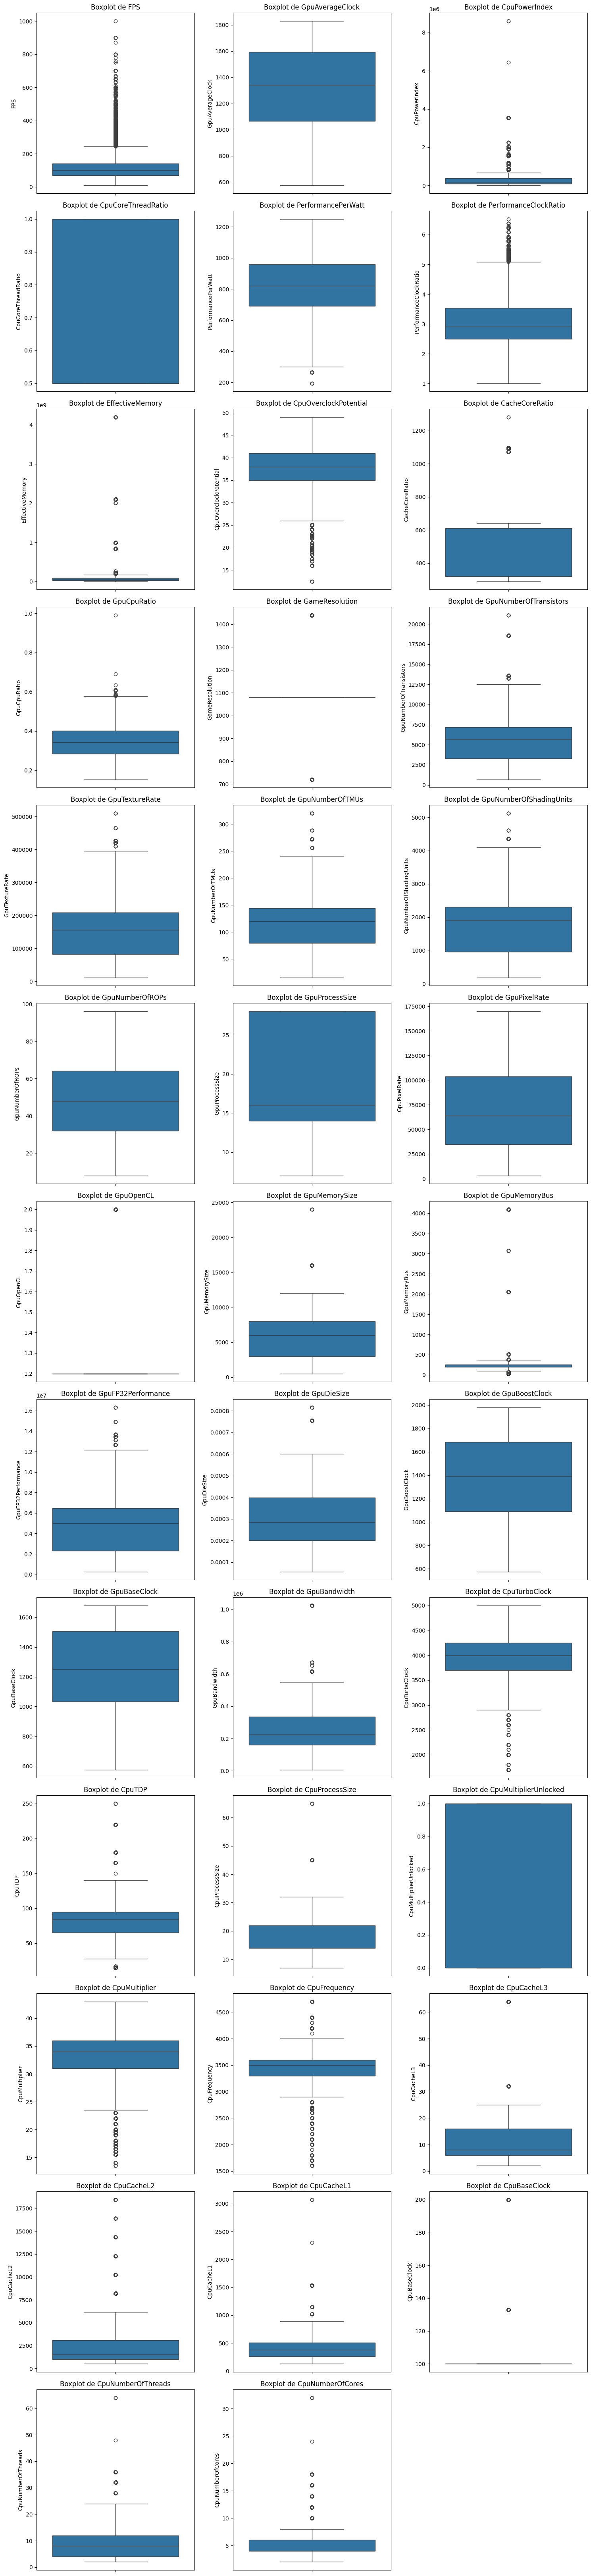

In [27]:
# Visualize the distribution of each numerical variable
def create_boxplots(df, columns=None):
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns
    num_cols = len(columns)
    num_rows = (num_cols + 2) // 3
    plt.figure(figsize=(15, 5 * num_rows))
    for i, col in enumerate(reversed(columns)):
        plt.subplot(num_rows, 3, i + 1)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot de {col}')
        plt.ylabel(col)
    plt.tight_layout()
    plt.show()
    
create_boxplots(df)

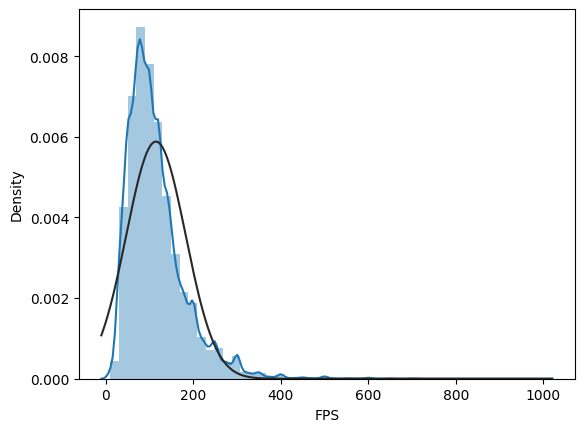

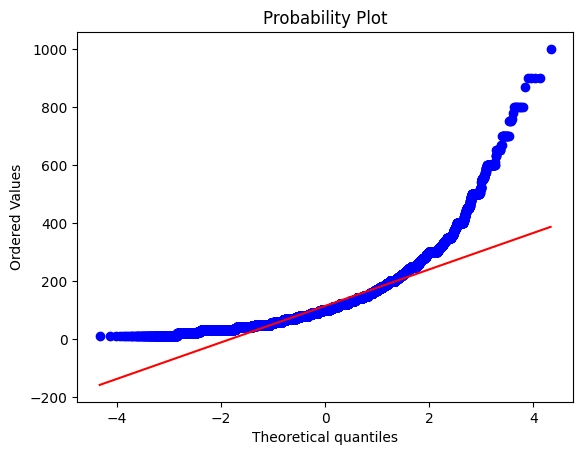

In [28]:
# Visualize the distribution of the objective variable (FPS)
sns.distplot(df['FPS'],fit=norm);
fig = plt.figure()
res = stats.probplot(df['FPS'], plot=plt)

Con base en el conocimiento del negocio, sabemos que los juegos pueden considerarse jugables de manera aceptable cuando los FPS (fotogramas por segundo) están entre 0 y 60, se consideran buenos cuando los FPS varían entre 60 y 144, y son excelentes cuando superan los 144 FPS. Por lo tanto, transformaremos la variable numérica FPS en una variable categórica para mejorar el rendimiento del modelo.

In [29]:
# We transform the FPS variable to a categorical variable in 3 categories
df['FPS'] = pd.cut(df['FPS'], bins=[0, 60, 144, 1100], labels=['Playable', 'Good', 'Excelent'])
df['FPS'].value_counts()

FPS
Good        52631
Excelent    22206
Playable    18858
Name: count, dtype: int64

In [30]:
# View columns that are categorical
df.select_dtypes(include='object').columns

Index(['GpuArchitecture', 'GpuBus nterface', 'GpuDirectX', 'GpuMemoryType',
       'GameName', 'GameSetting'],
      dtype='object')

In [31]:
# Separating the features in nominal and ordinal categories
nominal = ['GpuArchitecture', 'GameName']
ordinal = ['GpuBus nterface', 'GpuDirectX', 'GpuMemoryType', 'GameSetting']

#MODELO CPU, MODELO GPU, JUEGO

In [32]:
# Mapping the ordinal columns
mappings = [
    {
        'col': 'GpuBus nterface',
        'mapping': {
            'PCIe 2.0 x8': 0,
            'PCIe 2.0 x16': 1,
            'PCIe 3.0 x4': 2,
            'PCIe 3.0 x8': 3,
            'PCIe 3.0 x16': 4,
            'MXM-A (3.0)': 5,
            'MXM-B (3.0)': 6,
            'PCIe 4.0 x16': 7,
        } 
    },
    {
        'col': 'GpuDirectX',
        'mapping': {
            '12': 0,
            '12 Ultimate': 1,
        }
    },
    {
        'col': 'GpuMemoryType',
        'mapping': {
            'GDDR3': 0,
            'DDR3': 1,
            'GDDR5': 2,
            'GDDR5X': 3,
            'GDDR6': 4,
            'HBM': 5,
            'HBM2': 6,
        }
    },
    {
        'col': 'GameSetting',
        'mapping': {
            'low': 0,
            'med': 1,
            'high': 2,
            'max': 3,
        }
    },
]

In [33]:
# One-hot encoding the nominal columns and ordinal encoding the ordinal columns
onehotenc = OneHotEncoder(cols = nominal)
ordinalenc = OrdinalEncoder(cols = ordinal, mapping = mappings)

In [34]:
# Splitting the dataset into features and target
X = df.drop('FPS', axis = 'columns')
Y = df['FPS']

In [35]:
# We create a pipeline to preprocess the data
nominal_transformer = Pipeline(
    steps=[
        ('nominal', onehotenc)
    ]
)
ordinal_transformer = Pipeline(
    steps=[
        ('ordinal', ordinalenc)
    ]
)

mapper = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal),
        ('ordinal', ordinal_transformer, ordinal)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(
    steps=[
        ('mapper', mapper),
        ('scaler', StandardScaler())
    ]
)

In [36]:
# Convert the data to a DataFrame after preprocessing
encoded = pipeline.fit_transform(X)
data = pd.DataFrame(encoded, columns=pipeline.named_steps['mapper'].get_feature_names_out())
print(data.shape)
data.head()

(93695, 85)


,nominal__GpuArchitecture_1,nominal__GpuArchitecture_2,nominal__GpuArchitecture_3,nominal__GpuArchitecture_4,nominal__GpuArchitecture_5,nominal__GpuArchitecture_6,nominal__GpuArchitecture_7,nominal__GpuArchitecture_8,nominal__GpuArchitecture_9,nominal__GpuArchitecture_10,nominal__GpuArchitecture_11,nominal__GpuArchitecture_12,nominal__GpuArchitecture_13,nominal__GpuArchitecture_14,nominal__GameName_1,nominal__GameName_2,nominal__GameName_3,nominal__GameName_4,nominal__GameName_5,nominal__GameName_6,nominal__GameName_7,nominal__GameName_8,nominal__GameName_9,nominal__GameName_10,nominal__GameName_11,nominal__GameName_12,nominal__GameName_13,nominal__GameName_14,nominal__GameName_15,nominal__GameName_16,nominal__GameName_17,nominal__GameName_18,nominal__GameName_19,nominal__GameName_20,nominal__GameName_21,nominal__GameName_22,nominal__GameName_23,nominal__GameName_24,nominal__GameName_25,nominal__GameName_26,nominal__GameName_27,nominal__GameName_28,nominal__GameName_29,nominal__GameName_30,ordinal__GpuBus nterface,ordinal__GpuDirectX,ordinal__GpuMemoryType,ordinal__GameSetting,remainder__CpuNumberOfCores,remainder__CpuNumberOfThreads,remainder__CpuBaseClock,remainder__CpuCacheL1,remainder__CpuCacheL2,remainder__CpuCacheL3,remainder__CpuFrequency,remainder__CpuMultiplier,remainder__CpuMultiplierUnlocked,remainder__CpuProcessSize,remainder__CpuTDP,remainder__CpuTurboClock,remainder__GpuBandwidth,remainder__GpuBaseClock,remainder__GpuBoostClock,remainder__GpuDieSize,remainder__GpuFP32Performance,remainder__GpuMemoryBus,remainder__GpuMemorySize,remainder__GpuOpenCL,remainder__GpuPixelRate,remainder__GpuProcessSize,remainder__GpuNumberOfROPs,remainder__GpuNumberOfShadingUnits,remainder__GpuNumberOfTMUs,remainder__GpuTextureRate,remainder__GpuNumberOfTransistors,remainder__GameResolution,remainder__GpuCpuRatio,remainder__CacheCoreRatio,remainder__CpuOverclockPotential,remainder__EffectiveMemory,remainder__PerformanceClockRatio,remainder__PerformancePerWatt,remainder__CpuCoreThreadRatio,remainder__CpuPowerIndex,remainder__GpuAverageClock
0,2.591273,-0.273504,-0.187711,-0.681282,-0.135163,-0.340023,-0.120226,-0.13185,-0.406628,-0.354135,-0.153214,-0.142511,-0.024888,-0.006534,3.227456,-0.177953,-0.299084,-0.230964,-0.334626,-0.319895,-0.300226,-0.232983,-0.202308,-0.265323,-0.131136,-0.159272,-0.204073,-0.198795,-0.144986,-0.152189,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-1.192351,-0.334133,-0.528652,-0.753155,-1.557178,-0.934173,-0.363226,-0.935178,-0.662433,-0.769683,-0.76658,-0.10481,-1.207621,-0.494537,-2.056202,-1.850897,-1.473948,-0.584372,-0.619360,-1.371452,-1.283650,-0.609834,-1.152785,1.782736,-1.247174,-0.731210,-1.404642,-1.393719,-1.452804,-1.335471,-1.104300,0.079105,0.354949,0.480816,-0.748145,-0.436408,-0.496535,-1.466322,-0.866799,-0.604954,-0.607137
1,2.591273,-0.273504,-0.187711,-0.681282,-0.135163,-0.340023,-0.120226,-0.13185,-0.406628,-0.354135,-0.153214,-0.142511,-0.024888,-0.006534,-0.309842,5.619451,-0.299084,-0.230964,-0.334626,-0.319895,-0.300226,-0.232983,-0.202308,-0.265323,-0.131136,-0.159272,-0.204073,-0.198795,-0.144986,-0.152189,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-0.105222,-1.192351,-0.334133,-0.528652,0.161551,-1.557178,-0.934173,-0.363226,-0.935178,-0.662433,-0.769683,-0.76658,-0.10481,-1.207621,-0.494537,-2.056202,-1.850897,-1.473948,-0.584372,-0.619360,-1.371452,-1.283650,-0.609834,-1.152785,1.782736,-1.247174,-0.731210,-1.404642,-1.393719,-1.452804,-1.335471,-1.104300,-1.804441,0.354949,0.480816,-0.748145,-0.436408,-0.496535,-1.466322,-0.866799,-0.604954,-0.607137
2,-0.385911,3.656254,-0.187711,-0.681282,-0.135163,-0.340023,-0.120226,-0.13185,-0.406628,-0.354135,-0.153214,-0.142511,-0.024888,-0.006534,-0.309842,-0.177953,3.343539,-0.230964,-0.334626,-0.319895,-0.300226,-0.232983,-0.202308,-0.265323,-0.13113

In [37]:
# Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((74956, 85), (18739, 85), (74956,), (18739,))

## Modelization

Definimos como métrica de validación el precision_weighted ya que es una métrica útil para problemas de multiclase desbalanceados. Este mide la precisión teniendo en cuenta el tamaño de cada clase, lo cual es importante cuando el rendimiento de cada clase es relevante pero no todas las clases tienen la misma cantidad de ejemplos.

Utilizaremos los modelos de Random Forest Classifier y LightGBM

### Random Forest Classifier

In [38]:
# Basic model of Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=123, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# View model metrics
print(classification_report(y_test, y_pred))

# Cross-validation with precision_weighted
cv = KFold(n_splits=5, shuffle=True, random_state=123)
scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='precision_weighted', n_jobs=-1)
print(f'Cross-validation scores: {scores}')
print(f'Cross-validation mean score: {scores.mean()}')

              precision    recall  f1-score   support

    Excelent       0.78      0.74      0.76      4482
        Good       0.78      0.83      0.80     10476
    Playable       0.70      0.62      0.66      3781

    accuracy                           0.76     18739
   macro avg       0.75      0.73      0.74     18739
weighted avg       0.76      0.76      0.76     18739

Cross-validation scores: [0.75828684 0.75923142 0.76071092 0.76148959 0.76163237]
Cross-validation mean score: 0.7602702286627452


Obtenemnos un precision weighted del 76.0% con un modelo básico de Random Forest. Ahora veremos las variables que han tomado más importancia en el entrenamiento del modelo.

In [345]:
# View importance of predictors
importancia_predictores = pd.DataFrame({'predictor': data.columns, 'importancia': rf.feature_importances_})
importancia_predictores.sort_values('importancia', ascending=True).T

,13,12,11,10,4,6,7,2,45,9,1,0,8,5,3,44,67,31,36,40,34,30,69,46,33,65,35,50,41,39,38,32,37,25,42,63,43,29,70,24,72,56,61,48,71,66,17,60,28,62,26,21,27,22,52,14,51,74,49,20,73,15,68,19,53,64,57,16,58,23,54,55,59,75,18,47
predictor,nominal__GpuArchitecture_14,nominal__GpuArchitecture_13,nominal__GpuArchitecture_12,nominal__GpuArchitecture_11,nominal__GpuArchitecture_5,nominal__GpuArchitecture_7,nominal__GpuArchitecture_8,nominal__GpuArchitecture_3,ordinal__GpuDirectX,nominal__GpuArchitecture_10,nominal__GpuArchitecture_2,nominal__GpuArchitecture_1,nominal__GpuArchitecture_9,nominal__GpuArchitecture_6,nominal__GpuArchitecture_4,ordinal__GpuBus nterface,remainder__GpuOpenCL,nominal__GameName_18,nominal__GameName_23,nominal__GameName_27,nominal__GameName_21,nominal__GameName_17,remainder__GpuProcessSize,ordinal__GpuMemoryType,nominal__GameName_20,remainder__GpuMemoryBus,nominal__GameName_22,remainder__CpuBaseClock,nominal__GameName_28,nominal__GameName_26,nominal__GameName_25,nominal__GameName_19,nominal__GameName_24,nominal__GameName_12,nominal__GameName_29,remainder__GpuDieSize,nominal__GameName_30,nominal__GameName_16,remainder__GpuNumberOfROPs,nominal__GameName_11,remainder__GpuNumberOfTMUs,remainder__CpuMultiplierUnlocked,remainder__GpuBaseClock,remainder__CpuNumberOfCores,remainder__GpuNumberOfShadingUnits,remainder__GpuMemorySize,nominal__GameName_4,remainder__GpuBandwidth,nominal__GameName_15,remainder__GpuBoostClock,nominal__GameName_13,nominal__GameName_8,nominal__GameName_14,nominal__GameName_9,remainder__CpuCacheL2,nominal__GameName_1,remainder__CpuCacheL1,remainder__GpuNumberOfTransistors,remainder__CpuNumberOfThreads,nominal__GameName_7,remainder__GpuTextureRate,nominal__GameName_2,remainder__GpuPixelRate,nominal__GameName_6,remainder__CpuCacheL3,remainder__GpuFP32Performance,remainder__CpuProcessSize,nominal__GameName_3,remainder__CpuTDP,nominal__GameName_10,remainder__CpuFrequency,remainder__CpuMultiplier,remainder__CpuTurboClock,remainder__GameResolution,nominal__GameName_5,ordinal__GameSetting
importancia,0.000008,0.000031,0.000173,0.000175,0.000242,0.000247,0.000423,0.000589,0.000789,0.000931,0.000964,0.00097,0.001043,0.001083,0.001213,0.001578,0.001624,0.002604,0.002711,0.002777,0.002959,0.003526,0.003529,0.003885,0.004083,0.004114,0.004391,0.004421,0.005378,0.005631,0.005929,0.006362,0.006568,0.006962,0.007877,0.008078,0.008093,0.00822,0.008835,0.008949,0.009888,0.009957,0.010832,0.011341,0.011619,0.011713,0.012344,0.012637,0.013355,0.013483,0.013651,0.013805,0.014023,0.014067,0.015287,0.015693,0.016154,0.016838,0.017567,0.017994,0.018793,0.018918,0.019705,0.020296,0.021964,0.022224,0.022482,0.025038,0.032513,0.035665,0.038675,0.042373,0.049169,0.055039,0.067896,0.099039


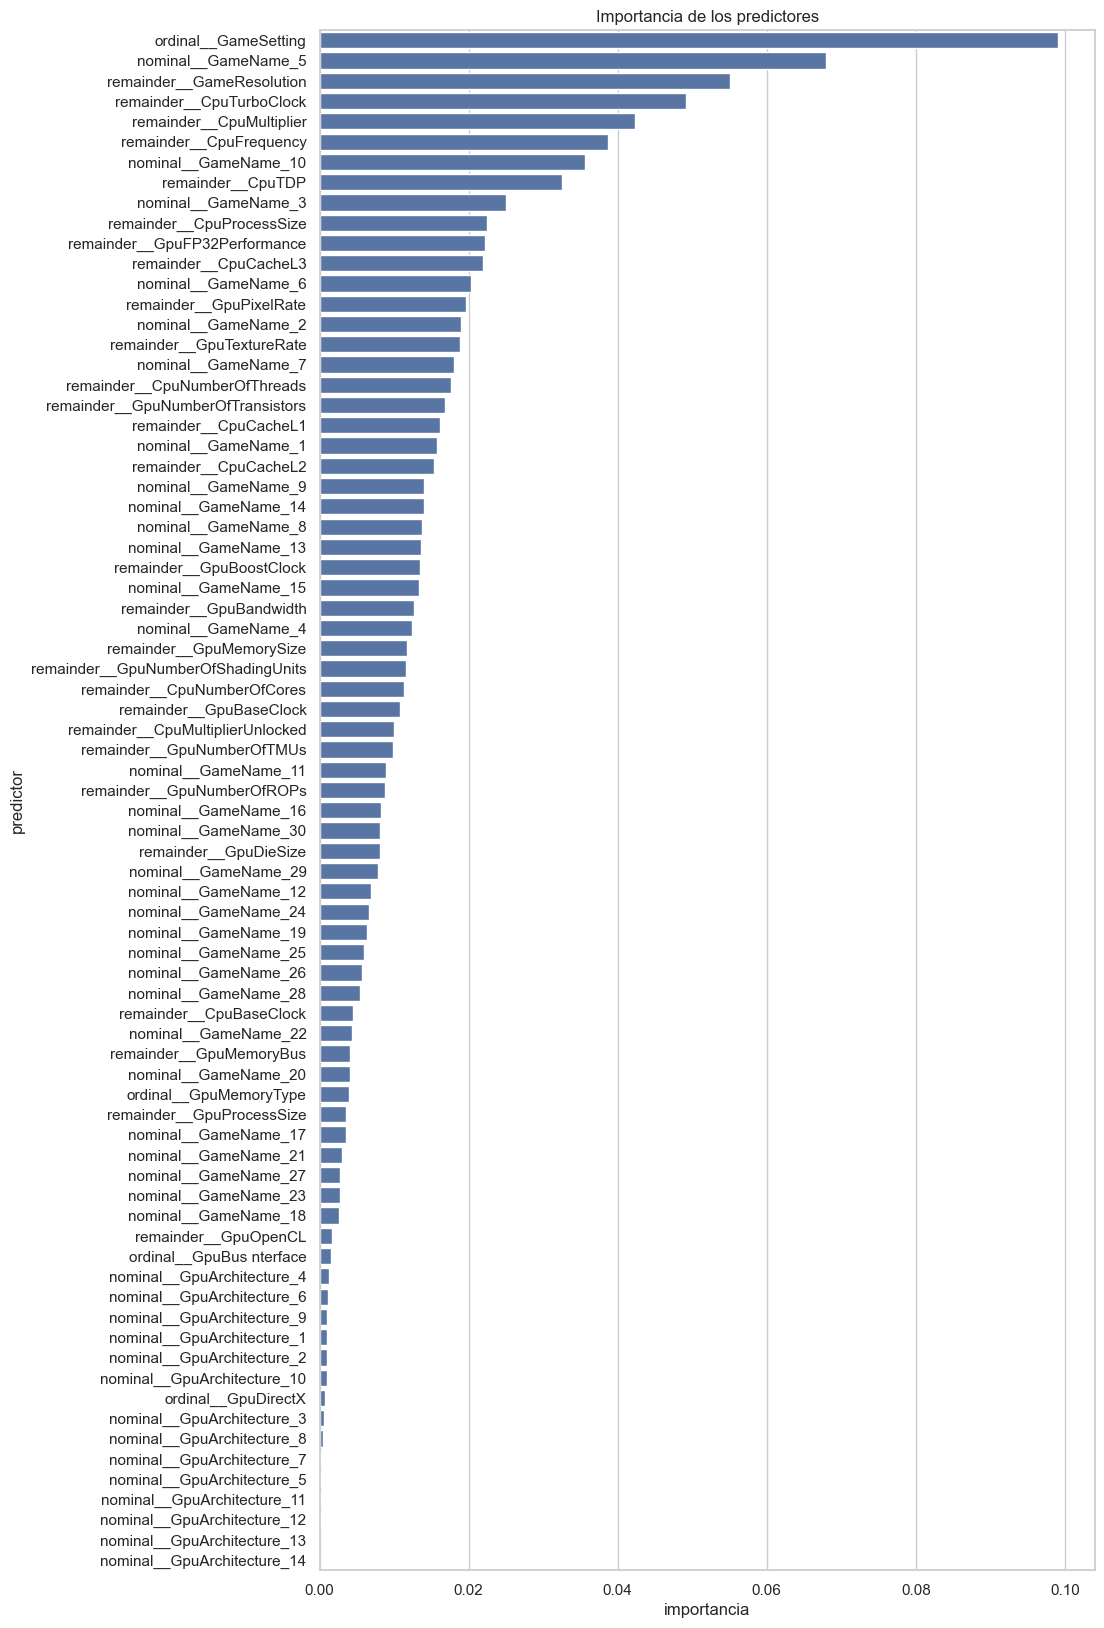

In [346]:
# graph importance of variables sorting descending
plt.figure(figsize=(10, 20))
sns.barplot(x='importancia', y='predictor', data=importancia_predictores.sort_values('importancia', ascending=False))
plt.title('Importancia de los predictores')
plt.show()

Hemos identificado que hay tres variables que no aportan ninguna importancia al modelo, así como otras con una importancia muy baja, lo que limita la capacidad de generalización del modelo. Por lo tanto, realizaremos un nuevo entrenamiento del Random Forest Classifier, eliminando estas variables, para evaluar la diferencia en términos de precisión.

In [355]:
# Train again without predictors with less than 1% importance
drop_columns = importancia_predictores[importancia_predictores['importancia'] < 0.01]
data.drop(columns = drop_columns['predictor'], axis=1, inplace=True)
# Splitting the new data into training and testing
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)

# Train again the basic model of Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=123, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# View model metrics
print(classification_report(y_test, y_pred))

# Cross-validation with precision_weighted
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='precision_weighted')
print(f'Cross-validation scores: {scores}')
print(f'Cross-validation mean score: {scores.mean()}')

              precision    recall  f1-score   support

    Excelent       0.70      0.68      0.69      4482
        Good       0.75      0.79      0.77     10476
    Playable       0.69      0.61      0.64      3781

    accuracy                           0.73     18739
   macro avg       0.71      0.69      0.70     18739
weighted avg       0.72      0.73      0.72     18739

Cross-validation scores: [0.71713029 0.72034178 0.7311702  0.72086598 0.72710714]
Cross-validation mean score: 0.7233230778700862


Después de eliminar las variables con menos del 1% de importancia, observamos que la precisión del modelo no ha cambiado significativamente. Sin embargo, el tiempo de ejecución del modelo ha disminuido y como la precisión es parecida, nos lleva a concluir que el modelo ahora generaliza mejor.

### Tunning Random Forest Classifier with Optuna

Ahora al modelo de Random Forest Classifier se le realizará un tuneo de hiperparámetros con la técnica genética avanzada Optuna

In [179]:
def objective(trial):
    # We define the hyperparameters to optimize the model
    n_estimators = trial.suggest_int("n_estimators", 10, 500, step=20)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "random_state": 100
    }
    model = RandomForestClassifier(**params)    
    
    # To validate the model we use cross-validation with precision_weighted
    cv_score = cross_val_score(model, X_train, y_train, scoring="precision_weighted", cv=5)
    mean_cv_precision = cv_score.mean()
    return mean_cv_precision

# We create the study to optimize the hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=-1)

print('Mejores hiperparámetros:', study.best_params)
print('Mejor score de precisión ponderada:', study.best_value)

[I 2024-11-15 00:02:42,952] A new study created in memory with name: no-name-864251a6-ddb6-4347-831b-b0439b7de931


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-11-15 00:03:00,928] Trial 12 finished with value: 0.7033644495672954 and parameters: {'n_estimators': 10, 'max_depth': 11, 'min_samples_split': 7}. Best is trial 12 with value: 0.7033644495672954.
[I 2024-11-15 00:03:05,857] Trial 13 finished with value: 0.7010166629258634 and parameters: {'n_estimators': 10, 'max_depth': 17, 'min_samples_split': 2}. Best is trial 12 with value: 0.7033644495672954.
[I 2024-11-15 00:03:07,774] Trial 15 finished with value: 0.7013275655737193 and parameters: {'n_estimators': 10, 'max_depth': 18, 'min_samples_split': 3}. Best is trial 12 with value: 0.7033644495672954.
[I 2024-11-15 00:03:31,677] Trial 0 finished with value: 0.7112279437193567 and parameters: {'n_estimators': 30, 'max_depth': 12, 'min_samples_split': 6}. Best is trial 0 with value: 0.7112279437193567.
[I 2024-11-15 00:03:39,868] Trial 18 finished with value: 0.6968804846480149 and parameters: {'n_estimators': 30, 'max_depth': 7, 'min_samples_split': 7}. Best is trial 0 with value:

In [115]:
# Train with the best hyperparameters of RandomForestClassifier
rf_model_best_params = RandomForestClassifier(n_estimators = 430, max_depth = 19, min_samples_split = 10)
rf_model_best_params.fit(X_train, y_train)
y_pred = rf_model_best_params.predict(X_test)

# View model metrics
print(classification_report(y_test, y_pred))

# Cross-validation with precision_weighted
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_model_best_params, X_train, y_train, cv=cv, scoring='precision_weighted')
print(f'Cross-validation scores: {scores}')
print(f'Cross-validation mean score: {scores.mean()}')

              precision    recall  f1-score   support

    Excelent       0.74      0.70      0.72      6945
        Good       0.71      0.82      0.76     10869
    Playable       0.64      0.31      0.41      2565

    accuracy                           0.71     20379
   macro avg       0.70      0.61      0.63     20379
weighted avg       0.71      0.71      0.70     20379

Cross-validation scores: [0.71538174 0.72250277 0.72182679 0.71457675 0.71721908]
Cross-validation mean score: 0.7183014257265159


Tras ejecutar Optuna, observamos una mejora en la precisión, que pasó del 68.4% a 71.8% al utilizar los mejores hiperparámetros encontrados con Optuna. Esto sugiere que, con una búsqueda más exhaustiva, la precisión podría incrementarse aún más.

### LightGBM Classifier

Para entrenar el LightGBM Classifier, convertimos la variable objetivo a formato numérico, asignando los valores 0 para "Playable", 1 para "Good" y 2 para "Excellent".

In [357]:
# Convert the target variable to a numerical variable in range 0 to 2
y_train = y_train.astype('category').cat.codes
y_test = y_test.astype('category').cat.codes

In [358]:
# Basic model of LGBMClassifier
lgbm_model_basic = LGBMClassifier(n_estimators = 100, random_state = 123, n_jobs=-1)
lgbm_model_basic.fit(X = X_train, y = y_train)
y_pred = lgbm_model_basic.predict(X = X_test)

# View model metrics
print(classification_report(y_test, y_pred))

# Cross-validation with precision_weighted
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lgbm_model_basic, X_train, y_train, cv=cv, scoring='precision_weighted')
print(f'Cross-validation scores: {scores}')
print(f'Cross-validation mean score: {scores.mean()}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 74956, number of used features: 34
[LightGBM] [Info] Start training from score -1.603731
[LightGBM] [Info] Start training from score -0.575548
[LightGBM] [Info] Start training from score -1.441982
              precision    recall  f1-score   support

           0       0.75      0.63      0.68      3781
           1       0.76      0.84      0.80     10476
           2       0.75      0.69      0.72      4482

    accuracy                           0.76     18739
   macro avg       0.76      0.72      0.73     18739
weighted avg       0.76      0.76      0.76     18739

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002287 seconds.


Después de utilizar un modelo básico de LGBM obtenemos una precisión de 75.4%.

### LGBM Classifier with Optuna

Ahora realizaremos su optimización de hiperparámetros utilizando la técnica genética avanzada optuna.

In [187]:
def objective(trial):
    # Define the hiperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 300, step=10)
    max_depth = trial.suggest_int("max_depth", 3, 8)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 0.1)  
    subsample = trial.suggest_uniform("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.5, 1.0)
    min_child_samples = trial.suggest_int("min_child_samples", 10, 100, step=10)
    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "min_child_samples": min_child_samples,
        "random_state": 100
    }
    lgbm_model = LGBMClassifier(**params)
    
    # we validate the model with cross-validation with the metric precision_weighted
    cv_score = cross_val_score(lgbm_model, X_train, y_train, scoring="precision_weighted", n_jobs=-1, cv=5)
    mean_cv_precision = cv_score.mean()
    
    return mean_cv_precision

# Optimización con Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=-1)

# Imprimimos los mejores parámetros y el mejor score de precisión ponderada
print('Mejores hiperparámetros:', study.best_params) 
print('Mejor score de precisión ponderada:', study.best_value)

[I 2024-11-15 00:40:25,217] A new study created in memory with name: no-name-c5a858f1-4181-40bb-bd33-10762fdf039e


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-11-15 00:40:48,541] Trial 10 finished with value: 0.6862867312898528 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.017305952326732228, 'subsample': 0.949590464851284, 'colsample_bytree': 0.768339540079308, 'min_child_samples': 10}. Best is trial 10 with value: 0.6862867312898528.
[I 2024-11-15 00:40:59,128] Trial 8 finished with value: 0.6001083782674201 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.003851360354132837, 'subsample': 0.7122751193077181, 'colsample_bytree': 0.6950004104333276, 'min_child_samples': 70}. Best is trial 10 with value: 0.6862867312898528.
[I 2024-11-15 00:41:07,206] Trial 2 finished with value: 0.5857564277843832 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.0024052829751946767, 'subsample': 0.6413242656601026, 'colsample_bytree': 0.9914112386879479, 'min_child_samples': 70}. Best is trial 10 with value: 0.6862867312898528.
[I 2024-11-15 00:41:44,881] Trial 11 finished wit

In [ ]:
# Train with the best hyperparameters of RandomForestClassifier
lgbm_model_best_params = LGBMClassifier(n_estimators = 280, max_depth = 6, learning_rate = 0.09587385007373754, subsample = 0.508378387756852, colsample_bytree = 0.5515979236349219, min_child_samples = 30)
lgbm_model_best_params.fit(X_train, y_train)
y_pred = lgbm_model_best_params.predict(X_test)

# Cross-validation with precision_weighted
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lgbm_model_best_params, X_train, y_train, cv=cv, scoring='precision_weighted')
print(f'Cross-validation scores: {scores}')
print(f'Cross-validation mean score: {scores.mean()}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1495
[LightGBM] [Info] Number of data points in the train set: 81515, number of used features: 78
[LightGBM] [Info] Start training from score -1.078020
[LightGBM] [Info] Start training from score -0.625363
[LightGBM] [Info] Start training from score -2.082132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Excelent       0.74      0.76      0.75      6945
        Good       0.74      0.80      0.77     10869
    Playable       0.67      0.40      0.50      2565

    accuracy                           0.74     20379
   macro avg       0.72      0.65      0.67     20379
weighted avg       0.73      0.74      0.73     20379



In [ ]:
# Save the model with the best hyperparameters
joblib.dump(rf_model_best_params, '../models/rf_model.pkl')
joblib.dump(lgbm_model_best_params, '../models/lgbm_model.pkl')

['../models/lgbm_model.pkl']

Al utilizar el modelo básico de LGBM Classifier se obtuvo un precision weighted de 74.10%. Sin embargo, al realizar el tuneo de hiperparámetros con optuna, se logró incrementar a 74.16%

## Dimensionality Reduction

Se utilizará PCA para reducir la dimensionalidad del conjunto de datos, manteniendo la mayor parte de la varianza importante. Dado el alto número de características relacionadas con las especificaciones de la CPU y GPU, PCA simplifica los datos sin perder información clave, facilitando su visualización y análisis. Por ello, evaluaremos si esta transformación mejora el rendimiento del modelo.

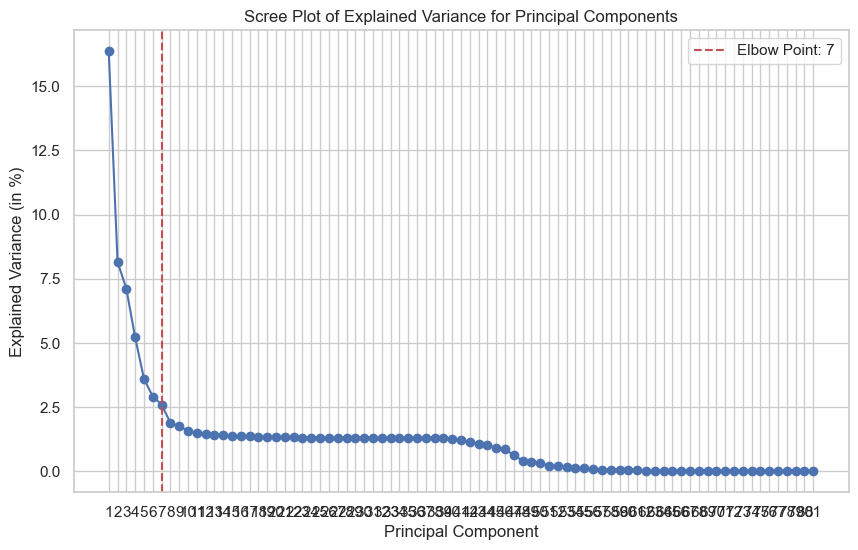

In [33]:
pca = PCA()
pca_results = pca.fit_transform(data)
explained_variance = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance)
elbow_point = np.argmax(np.diff(cumulative_variance) < 0.02) + 1 

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance * 100, marker='o')
plt.axvline(x=elbow_point, color='r', linestyle='--', label=f'Elbow Point: {elbow_point}')
plt.title('Scree Plot of Explained Variance for Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (in %)')
plt.xticks(range(1, len(explained_variance) + 1))
plt.legend()
plt.show()

In [ ]:
# Create a PCA object with 7 components
pca = PCA(n_components=7) 
principal_components = pca.fit_transform(data)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-5.488963,0.361669,-1.645457,1.491659,-2.162826,1.197624,0.390504
1,-5.488963,0.361669,-1.645457,1.491659,-2.162826,1.197624,0.390504
2,-5.757158,0.834804,-1.852654,1.833095,-2.356200,0.573284,1.750608
3,-5.757158,0.834804,-1.852654,1.833095,-2.356200,0.573284,1.750608
4,-5.266681,0.244650,-1.474872,1.318711,-1.877954,1.141154,0.136298
...,...,...,...,...,...,...,...
101889,-0.598973,1.359879,2.631615,3.934686,-1.263509,0.357584,-0.166811
101890,-1.268154,1.233110,1.327057,2.398776,0.130907,-0.186968,-0.328834
101891,-1.408425,1.037794,1.442439,1.959884,-0.173889,0.004072,-0.334166
101892,-1.464431,0.543286,1.483850,1.983249,-1.392468,0.526664,-0.101339


### Random forest with PCA

In [35]:
# Print shape of df and pca shape
data.shape, pca_df.shape

((101894, 81), (101894, 7))

In [36]:
# Dividing the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_df, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((81515, 7), (20379, 7), (81515,), (20379,))

In [37]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Excelent       0.64      0.65      0.65      6945
        Good       0.66      0.71      0.68     10869
    Playable       0.44      0.30      0.36      2565

    accuracy                           0.64     20379
   macro avg       0.58      0.55      0.56     20379
weighted avg       0.63      0.64      0.63     20379



### Random forest with PCA and Optuna

In [38]:
def objective(trial):
    # We define the hyperparameters to optimize the model
    n_estimators = trial.suggest_int("n_estimators", 10, 500, step=20)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "random_state": 100
    }
    model = RandomForestClassifier(**params)    
    
    # To validate the model we use cross-validation with precision_weighted
    cv_score = cross_val_score(model, X_train, y_train, scoring="precision_weighted", cv=5)
    mean_cv_precision = cv_score.mean()
    return mean_cv_precision

# We create the study to optimize the hyperparameters
study_rf_pca = optuna.create_study(direction="maximize")
study_rf_pca.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=-1)

print('Mejores hiperparámetros:', study_rf_pca.best_params)
print('Mejor score de precisión ponderada:', study_rf_pca.best_value)

[I 2024-11-16 14:00:01,881] A new study created in memory with name: no-name-3cca3c53-19b3-4b8e-97fb-08b3a4513037


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-11-16 14:00:14,072] Trial 1 finished with value: 0.5703189631001062 and parameters: {'n_estimators': 10, 'max_depth': 9, 'min_samples_split': 8}. Best is trial 1 with value: 0.5703189631001062.
[I 2024-11-16 14:00:36,072] Trial 4 finished with value: 0.6028575530745878 and parameters: {'n_estimators': 30, 'max_depth': 12, 'min_samples_split': 8}. Best is trial 4 with value: 0.6028575530745878.
[I 2024-11-16 14:01:03,653] Trial 15 finished with value: 0.5661601048506867 and parameters: {'n_estimators': 90, 'max_depth': 6, 'min_samples_split': 5}. Best is trial 4 with value: 0.6028575530745878.
[I 2024-11-16 14:01:19,041] Trial 16 finished with value: 0.5823773172180761 and parameters: {'n_estimators': 110, 'max_depth': 5, 'min_samples_split': 6}. Best is trial 4 with value: 0.6028575530745878.
[I 2024-11-16 14:01:40,690] Trial 3 finished with value: 0.6244936928604151 and parameters: {'n_estimators': 70, 'max_depth': 20, 'min_samples_split': 5}. Best is trial 3 with value: 0.624

KeyboardInterrupt: 

In [39]:
# Train with the best hyperparameters of RandomForestClassifier
rf_pca_model_best_params = RandomForestClassifier(**study_rf_pca.best_params)
rf_pca_model_best_params.fit(X_train, y_train)
y_pred = rf_pca_model_best_params.predict(X_test)

# View model metrics
print(classification_report(y_test, y_pred))

# Cross-validation with precision_weighted
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_pca_model_best_params, X_train, y_train, cv=cv, scoring='precision_weighted')
print(f'Cross-validation scores: {scores}')
print(f'Cross-validation mean score: {scores.mean()}')

              precision    recall  f1-score   support

    Excelent       0.66      0.57      0.62      6945
        Good       0.64      0.78      0.71     10869
    Playable       0.55      0.24      0.33      2565

    accuracy                           0.64     20379
   macro avg       0.62      0.53      0.55     20379
weighted avg       0.64      0.64      0.63     20379

Cross-validation scores: [0.62994643 0.62842825 0.63155622 0.6250228  0.62328595]
Cross-validation mean score: 0.6276479314508954


### LGBM with PCA

In [40]:
# Convert the target variable to a numerical variable in range 0 to 2
y_train = y_train.astype('category').cat.codes
y_test = y_test.astype('category').cat.codes

In [41]:
# Basic model of LGBMClassifier
lgbm_model_pca = LGBMClassifier(n_estimators = 100, random_state = 123)
lgbm_model_pca.fit(X = X_train, y = y_train)
y_pred = lgbm_model_pca.predict(X = X_test)

# View model metrics
print(classification_report(y_test, y_pred))

# Cross-validation with precision_weighted
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='precision_weighted')
print(f'Cross-validation scores: {scores}')
print(f'Cross-validation mean score: {scores.mean()}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 81515, number of used features: 7
[LightGBM] [Info] Start training from score -2.082132
[LightGBM] [Info] Start training from score -0.625363
[LightGBM] [Info] Start training from score -1.078020
              precision    recall  f1-score   support

           0       0.53      0.08      0.13      2565
           1       0.57      0.88      0.70     10869
           2       0.62      0.29      0.39      6945

    accuracy                           0.58     20379
   macro avg       0.58      0.42      0.41     20379
weighted avg       0.58      0.58      0.52     20379

Cross-validation scores: [0.6205165  0.62388014 0.61840908 0.6151744  0.61177594]
Cross-validation mean s

### LGBM with PCA and Optuna

In [42]:
def objective(trial):
    # Define the hiperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 300, step=10)
    max_depth = trial.suggest_int("max_depth", 3, 8)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 0.1)  
    subsample = trial.suggest_uniform("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.5, 1.0)
    min_child_samples = trial.suggest_int("min_child_samples", 10, 100, step=10)
    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "min_child_samples": min_child_samples,
        "random_state": 100
    }
    lgbm_LGBM_pca = LGBMClassifier(**params)
    
    # we validate the model with cross-validation with the metric precision_weighted
    cv_score = cross_val_score(lgbm_LGBM_pca, X_train, y_train, scoring="precision_weighted", n_jobs=-1, cv=5)
    mean_cv_precision = cv_score.mean()
    
    return mean_cv_precision

# Optimización con Optuna
study_LGBM_PCA = optuna.create_study(direction="maximize")
study_LGBM_PCA.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=-1)

# Imprimimos los mejores parámetros y el mejor score de precisión ponderada
print('Mejores hiperparámetros:', study_LGBM_PCA.best_params) 
print('Mejor score de precisión ponderada:', study_LGBM_PCA.best_value)

[I 2024-11-16 14:17:41,457] A new study created in memory with name: no-name-0dc4ada8-fe63-4296-b5f4-85d772f43294


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-11-16 14:18:04,747] Trial 1 finished with value: 0.28629687225421235 and parameters: {'n_estimators': 90, 'max_depth': 3, 'learning_rate': 0.001291929508343549, 'subsample': 0.5737627584870886, 'colsample_bytree': 0.8605862870398433, 'min_child_samples': 20}. Best is trial 1 with value: 0.28629687225421235.
[I 2024-11-16 14:18:05,387] Trial 0 finished with value: 0.5632786593872664 and parameters: {'n_estimators': 90, 'max_depth': 4, 'learning_rate': 0.022182245322031047, 'subsample': 0.8012097571657961, 'colsample_bytree': 0.6948803780761659, 'min_child_samples': 60}. Best is trial 0 with value: 0.5632786593872664.
[I 2024-11-16 14:18:17,934] Trial 10 finished with value: 0.5663154096584405 and parameters: {'n_estimators': 140, 'max_depth': 3, 'learning_rate': 0.024593581254027, 'subsample': 0.5461867254259889, 'colsample_bytree': 0.9453116464398021, 'min_child_samples': 40}. Best is trial 10 with value: 0.5663154096584405.
[I 2024-11-16 14:18:19,258] Trial 11 finished with va

In [55]:
# Train with the best hyperparameters of RandomForestClassifier
best_params = study_LGBM_PCA.best_params
lgbm_pca_optuna = LGBMClassifier(**best_params)
lgbm_pca_optuna.fit(X = X_train, y = y_train)
y_pred = lgbm_pca_optuna.predict(X_test)

# View model metrics
print(classification_report(y_test, y_pred))

# Cross-validation with precision_weighted
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lgbm_pca_optuna, X_train, y_train, cv=cv, scoring='precision_weighted')
print(f'Cross-validation scores: {scores}')
print(f'Cross-validation mean score: {scores.mean()}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 81515, number of used features: 7
[LightGBM] [Info] Start training from score -2.082132
[LightGBM] [Info] Start training from score -0.625363
[LightGBM] [Info] Start training from score -1.078020
              precision    recall  f1-score   support

           0       0.64      0.01      0.01      2565
           1       0.55      0.95      0.69     10869
           2       0.59      0.12      0.20      6945

    accuracy                           0.55     20379
   macro avg       0.59      0.36      0.30     20379
weighted avg       0.57      0.55      0.44     20379

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
Y